## Homework #4. Exploratory Data Analysis
#### Author: `ANDRII VALENIA`
#### Intermediate result time spent on h/w (in minutes): `300`
#### Total time spent on h/w (in minutes): `-`

Data analysis would be performed on the [dataset](https://www.kaggle.com/datasets/noahpersaud/89k-chatgpt-conversations/data) containing information about chatgpt conversations.

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Loading data

In [3]:
import pandas as pd

dataset_path = 'data/chatlogs-v2.jsonl'

df = pd.read_json(dataset_path, lines=True)

In [206]:
from tabulate import tabulate
df_copy = df.copy()
df_copy['conversation'] = df_copy['conversation'].apply(lambda x: ' '.join([msg['message'][:10] for msg in x]) if isinstance(x, list) else '')
print(tabulate(df_copy.head(), headers='keys', tablefmt='psql'))
del df_copy

+----+---------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|    | post_number   | system_message   | conversation                                                                                                                                                                                         |   message_count |
|----+---------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------|
|  0 | [57]          | ['']             | What is co Contrastiv Do we need In contras Right, but Yes, that' What is th The best a What are t Triplet lo                                                                        

Let's transform the data to a more convenient format where each row corresponds to a single conversation message.

In [ ]:
rows = []
for _, row in df.iterrows():
    post_number = row['post_number']
    conversation = row['conversation']
    
    if isinstance(conversation, list):
        for message_order, message in enumerate(conversation):
            user = message['user']
            text = message['message']
            rows.append({
                'post_number': post_number, 
                'user': user, 
                'message': text,
                'message_order': message_order
            })

df_expanded = pd.DataFrame(rows)

In [ ]:
df_expanded_truncated = df_expanded.copy()
df_expanded_truncated['message'] = df_expanded_truncated['message'].str[:20] + '...'
print(tabulate(df_expanded_truncated.head(), headers='keys', tablefmt='psql'))
print("Messages count:", len(df_expanded))
del df_expanded_truncated

+----+---------------+-----------+-------------------------+-----------------+
|    | post_number   | user      | message                 |   message_order |
|----+---------------+-----------+-------------------------+-----------------|
|  0 | [57]          | Anonymous | What is contrastive ... |               0 |
|  1 | [57]          | Chat GPT  | Contrastive loss is ... |               1 |
|  2 | [57]          | Anonymous | Do we need labels fo... |               2 |
|  3 | [57]          | Chat GPT  | In contrastive learn... |               3 |
|  4 | [57]          | Anonymous | Right, but we still ... |               4 |
+----+---------------+-----------+-------------------------+-----------------+
Messages count: 1549625


### General conversation analysis

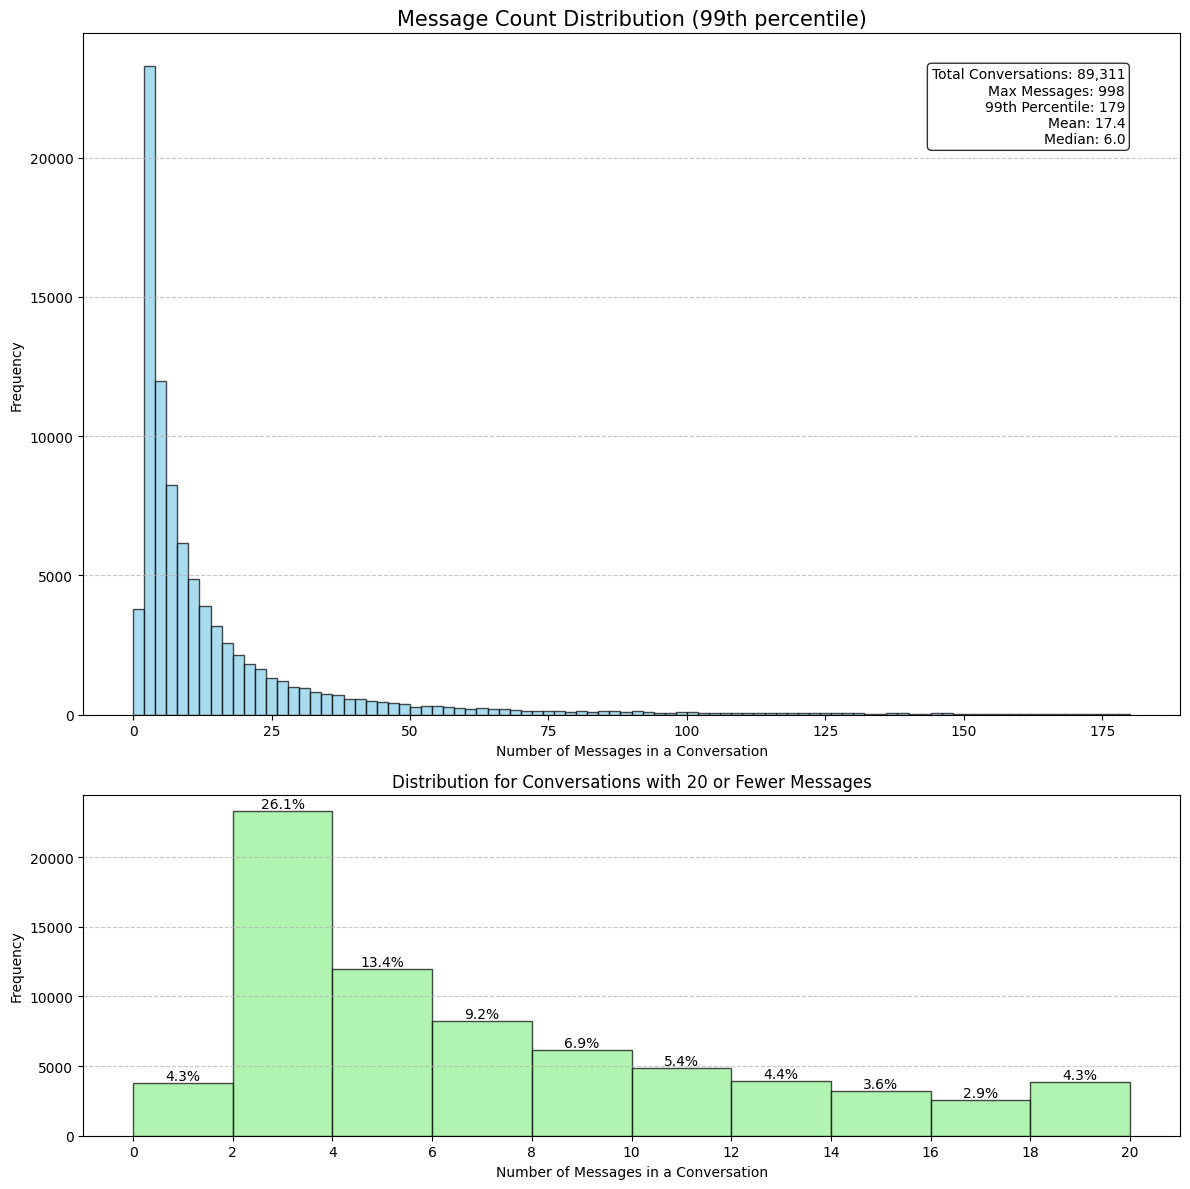

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df['message_count'] = df['conversation'].apply(lambda x: len(x) if isinstance(x, list) else 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2, 1])

max_percentile = np.percentile(df['message_count'], 99)
bins = np.arange(0, max_percentile + 2, 2)

ax1.hist(df['message_count'][df['message_count'] <= max_percentile], 
         bins=bins, 
         color='skyblue', 
         edgecolor='black',
         alpha=0.7)

ax1.set_title('Message Count Distribution (99th percentile)', fontsize=15)
ax1.set_xlabel('Number of Messages in a Conversation', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

stats_text = f'Total Conversations: {len(df):,}\n'
stats_text += f'Max Messages: {df["message_count"].max():,}\n'
stats_text += f'99th Percentile: {max_percentile:.0f}\n'
stats_text += f'Mean: {df["message_count"].mean():.1f}\n'
stats_text += f'Median: {df["message_count"].median():.1f}'

ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

small_plot_size = 20
bins_small = np.arange(0, small_plot_size + 2, 2)
counts, bins, patches = ax2.hist(df['message_count'][df['message_count'] <= small_plot_size], 
                                bins=bins_small, 
                                color='lightgreen', 
                                edgecolor='black',
                                alpha=0.7)

total = len(df)
for i, count in enumerate(counts):
    percentage = (count / total) * 100
    ax2.text(bins[i] + 1, count, f'{percentage:.1f}%',
             ha='center', va='bottom')

ax2.set_title('Distribution for Conversations with 20 or Fewer Messages', fontsize=12)
ax2.set_xlabel('Number of Messages in a Conversation', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_xticks(bins_small)

plt.tight_layout()
plt.show()

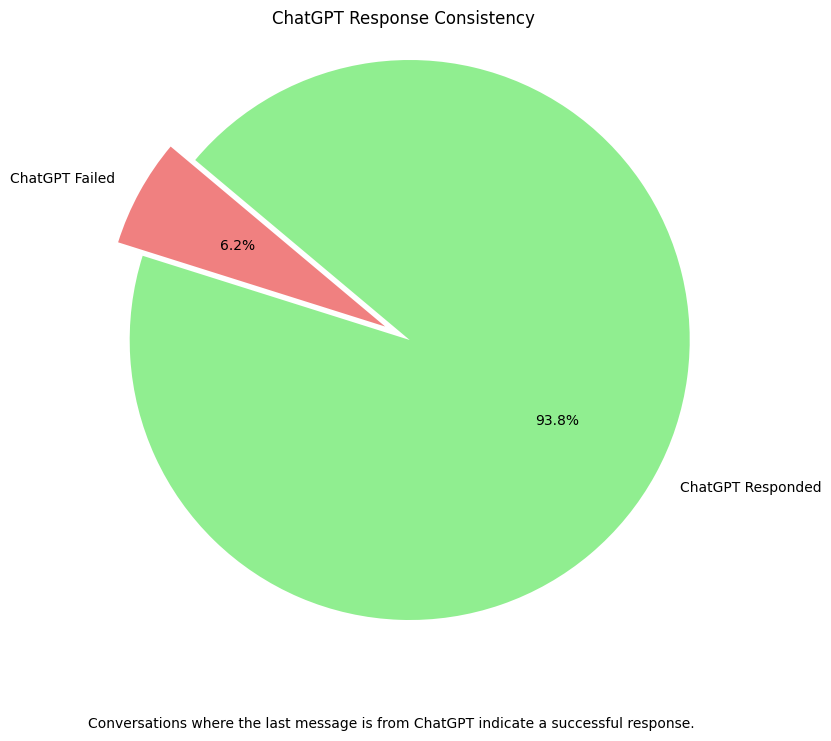

In [203]:
last_message_user = df_expanded.groupby('post_number').last()['user']
chatgpt_responded = last_message_user == 'Chat GPT'

chatgpt_responded_count = chatgpt_responded.sum()
chatgpt_failed_count = len(chatgpt_responded) - chatgpt_responded_count

labels = ['ChatGPT Failed', 'ChatGPT Responded']
sizes = [chatgpt_failed_count, chatgpt_responded_count]
colors = ['lightcoral', 'lightgreen']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0.1, 0))
plt.title('ChatGPT Response Consistency')
plt.figtext(0.5, 0.01, 'Conversations where the last message is from ChatGPT indicate a successful response.', ha='center', fontsize=10)
plt.axis('equal')
plt.show()

### Language analysis

Detect the language of the messages.

In [62]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect, LangDetectException
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

def safe_language_detect(text) -> str:
    try:
        return detect(str(text))
    except LangDetectException:
        return 'unknown'

def process_batch(texts):
    return [safe_language_detect(text) for text in texts]

def create_batches(df, batch_size=100) -> list:
    return [df['message'].iloc[i:i + batch_size].tolist() 
            for i in range(0, len(df), batch_size)]

def detect_languages(df, batch_size=100, max_workers=12) -> list:
    batches = create_batches(df, batch_size)
    results = []
    total_batches = len(batches)
    processed_batches = 0
    start_time = time()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]
        
        for future in as_completed(futures):
            batch_results = future.result()
            results.extend(batch_results)
            processed_batches += 1
            
            progress = processed_batches / total_batches
            elapsed_time = time() - start_time
            est_total_time = elapsed_time / progress if progress > 0 else 0
            est_remaining = est_total_time - elapsed_time
            print(f"\rProgress: {progress:.1%} | "
                    f"Processed: {processed_batches}/{total_batches} batches | "
                    f"Est. remaining: {est_remaining:.1f}s", end="")
    
    print("\nProcessing completed!")
    return results

from pathlib import Path
csv_path = 'data/expanded_chatlogs.csv'

if Path(csv_path).is_file():
    df_expanded = pd.read_csv(csv_path)
    print("Using existing CSV file.")
else:
    print("Detecting languages for each message...")
    df_expanded['language'] = detect_languages(df_expanded)
    df_expanded.to_csv(csv_path, index=False)

Using existing CSV file.


/var/folders/y5/0t8gc4cj315cwfcx9vxy3kgc0000gn/T/ipykernel_94916/2561151490.py:51: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_expanded = pd.read_csv(csv_path)


Took 54 minutes to detect language of each message.

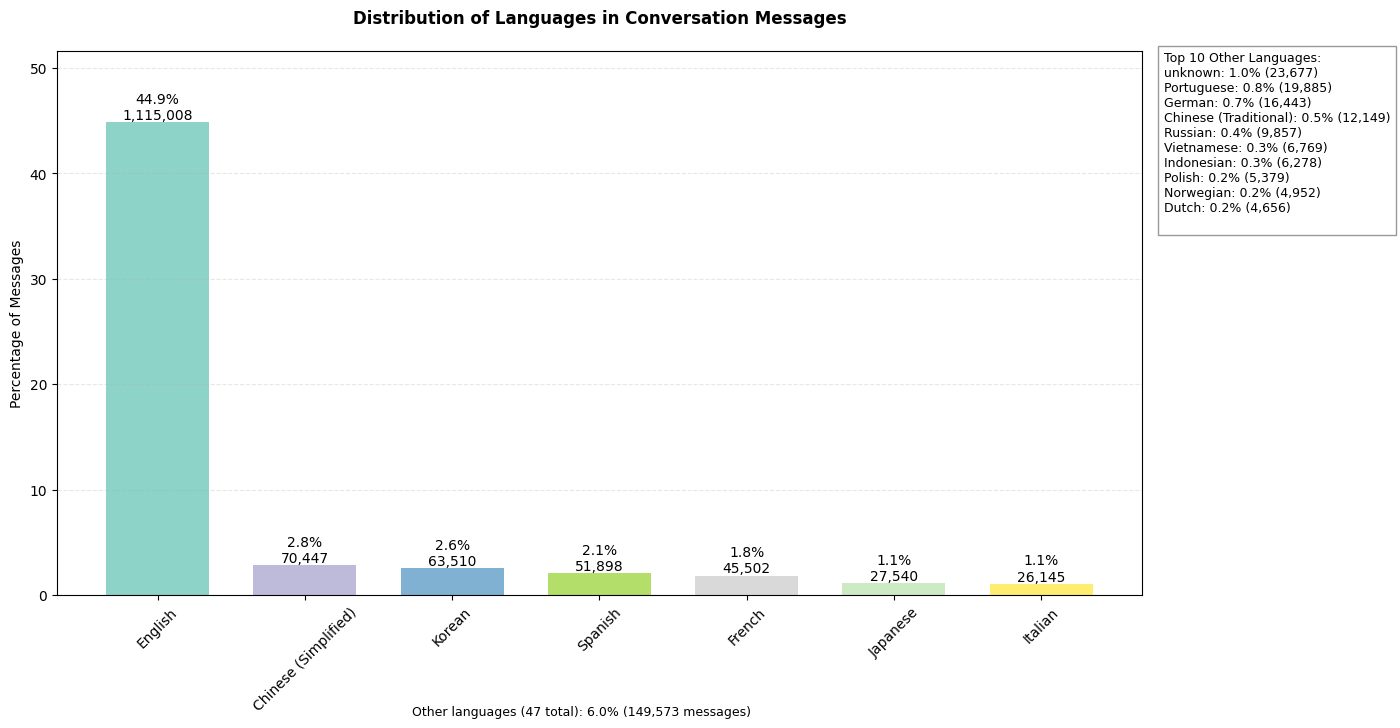

In [ ]:
import pycountry

def get_country_name(code):
    if code == 'zh-cn':
        return 'Chinese (Simplified)'
    elif code == 'zh-tw':
        return 'Chinese (Traditional)'
    country_info = pycountry.languages.get(alpha_2=code)
    return country_info.name if country_info else code

def plot_language_distribution(df, threshold_percent=2):
    language_counts = df['language'].value_counts()
    total_messages = len(df)
    
    percentages = (language_counts / total_messages) * 100
    percentages_sorted = percentages.sort_values(ascending=False)
    main_languages = percentages_sorted[percentages_sorted >= threshold_percent]
    other_languages = percentages_sorted[percentages_sorted < threshold_percent]
    
    plt.figure(figsize=(14, 8))
    
    main_ax = plt.gca()
    main_ax.bar(range(len(main_languages)), 
                main_languages,
                color=plt.cm.Set3(np.linspace(0, 1, len(main_languages))),
                width=0.7)
    
    for i, v in enumerate(main_languages):
        count = int(v * total_messages / 100)
        main_ax.text(i, v, f'{v:.1f}%\n{count:,}', 
                    ha='center', va='bottom', fontsize=10)
    
    main_ax.set_xticks(range(len(main_languages)))
    main_ax.set_xticklabels([get_country_name(lang) for lang in main_languages.index], rotation=45, fontsize=10)
    main_ax.set_ylabel('Percentage of Messages', fontsize=10)
    main_ax.set_ylim(0, max(main_languages) * 1.15)
    
    main_ax.set_title('Distribution of Languages in Messages', 
                      pad=20, size=12, weight='bold')
    
    main_ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    other_pct = other_languages.sum()
    other_count = int(other_pct * total_messages / 100)
    
    top_10_text = "Top 10 Other Languages:\n"
    for lang, pct in other_languages[:10].items():
        count = int(pct * total_messages / 100)
        top_10_text += f"{get_country_name(lang)}: {pct:.1f}% ({count:,})\n"
    
    main_ax.text(1.02, 1.0, top_10_text,
                 transform=main_ax.transAxes,
                 bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
                 fontsize=9,
                 verticalalignment='top')
    
    summary_text = f'Other languages ({len(other_languages)} total): {other_pct:.1f}% ({other_count:,} messages)'
    plt.figtext(0.5, 0.05, summary_text, ha='center', fontsize=9)
    plt.subplots_adjust(bottom=0.2)
    plt.show()

plot_language_distribution(df_expanded, threshold_percent=1)

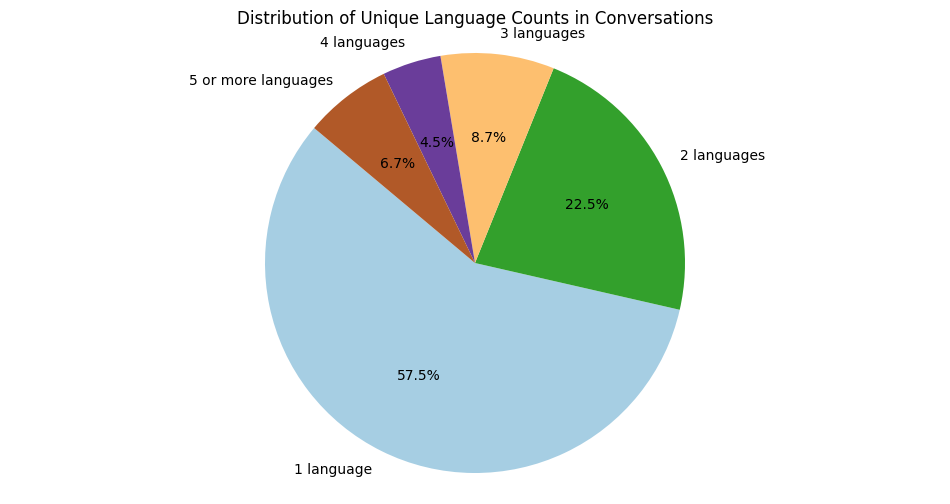

In [ ]:
language_counts_per_conversation = df_expanded.groupby('post_number')['language'].nunique().reset_index()
language_counts_per_conversation.columns = ['post_number', 'unique_language_count']
language_counts_per_conversation['unique_language_count'] = language_counts_per_conversation['unique_language_count'].apply(lambda x: '5 or more' if x >= 5 else str(x))
language_count_distribution = language_counts_per_conversation['unique_language_count'].value_counts().sort_index()
labels = [f'{count} language{"s" if count != "1" else ""}' for count in language_count_distribution.index]

plt.figure(figsize=(12, 6))
plt.pie(language_count_distribution, 
    labels=labels, 
    autopct='%1.1f%%', 
    colors=plt.cm.Paired(np.linspace(0, 1, len(language_count_distribution))),
    startangle=140)
plt.title('Distribution of Unique Language Counts in Conversations')
plt.axis('equal')
plt.show()


In [116]:
df_temp = df_expanded.copy()
df_temp['next_user'] = df_temp.groupby('post_number')['user'].shift(-1)
df_temp['next_language'] = df_temp.groupby('post_number')['language'].shift(-1)

pairs_df = df_temp[
    (df_temp['user'] != 'Chat GPT') & 
    (df_temp['next_user'] == 'Chat GPT')
].copy()

pairs_df = pairs_df[['post_number', 'language', 'next_language']].rename(
    columns={'language': 'user_language', 'next_language': 'chatgpt_language'}
)
pairs_df['pair_order'] = pairs_df.groupby('post_number').cumcount()
pairs_df


,post_number,user_language,chatgpt_language,pair_order
0,[57],unknown,unknown,0
2,[57],unknown,unknown,1
4,[57],unknown,unknown,2
6,[57],unknown,unknown,3
8,[57],unknown,unknown,4
...,...,...,...,...
2484151,[22628],en,en,73
2484153,[22628],en,en,74
2484155,[22628],en,en,75
2484157,[22628],en,en,76


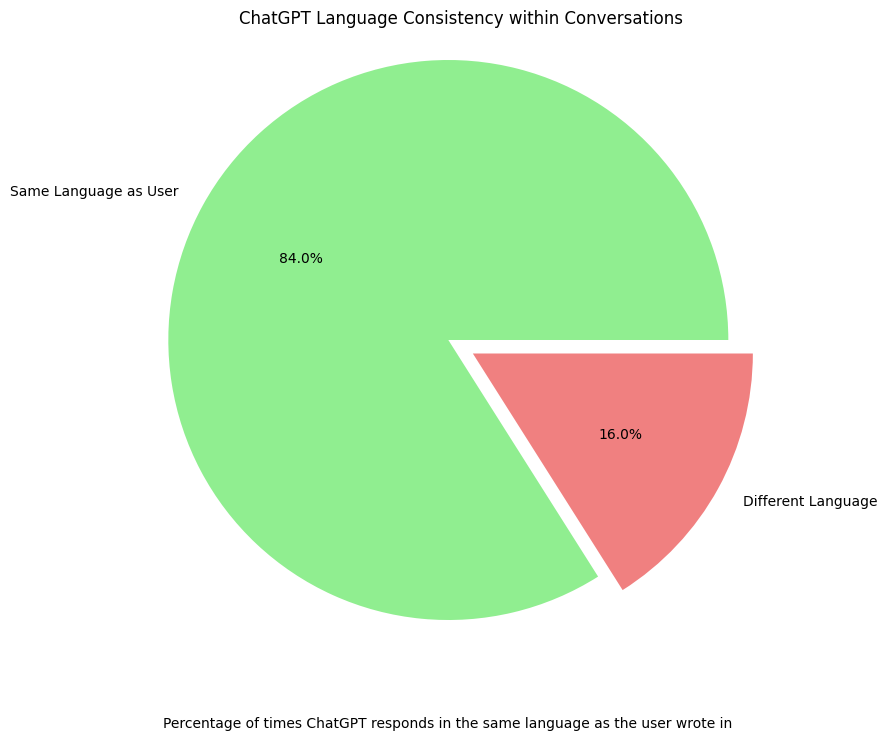

In [192]:
total_pairs = len(pairs_df)
matching_languages = (pairs_df['user_language'] == pairs_df['chatgpt_language']).sum()
percentage_matching = (matching_languages / total_pairs) * 100

plt.figure(figsize=(10, 8))
plt.pie([percentage_matching, 100-percentage_matching], 
        labels=['Same Language as User', 'Different Language'],
        colors=['lightgreen', 'lightcoral'],
        autopct='%1.1f%%',
        explode=(0.1, 0))
plt.title('ChatGPT Language Consistency within Conversations')
plt.figtext(0.5, 0.01, 'Percentage of times ChatGPT responds in the same language as the user wrote in', ha='center', fontsize=10)
plt.axis('equal')

plt.show()

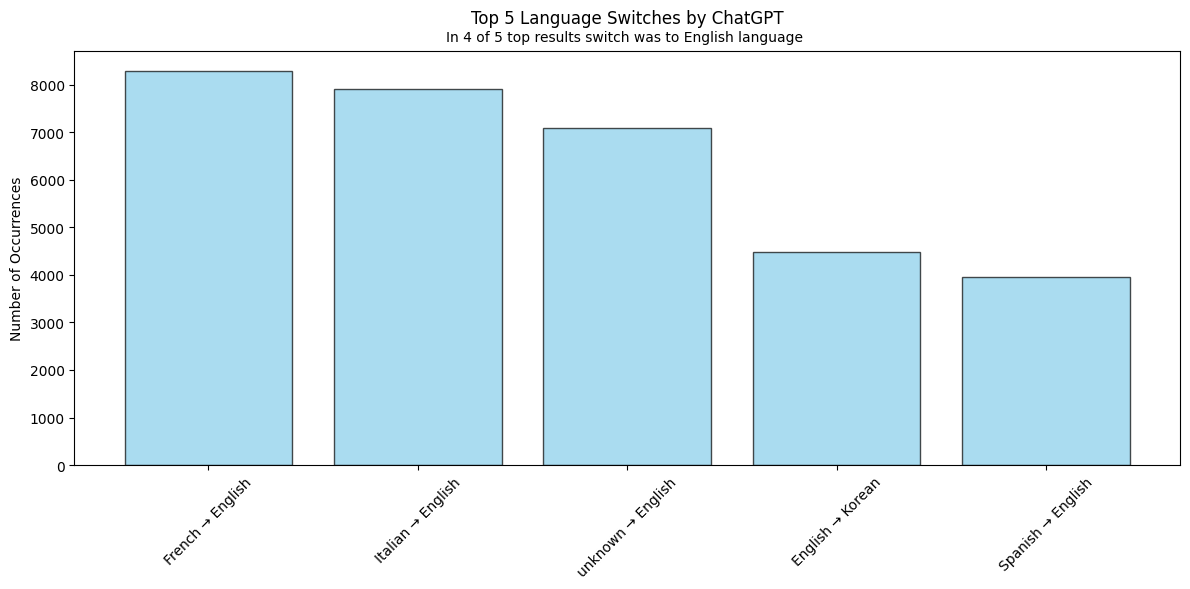

In [186]:
different_lang_responses = pairs_df[pairs_df['user_language'] != pairs_df['chatgpt_language']]

language_switches = different_lang_responses.groupby(['user_language', 'chatgpt_language']).size().reset_index()
language_switches.columns = ['User Language', 'ChatGPT Response', 'Count']
language_switches = language_switches.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
top_5_switches = language_switches.head(5)
plt.bar(range(len(top_5_switches)), top_5_switches['Count'], color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks(range(len(top_5_switches)), 
          [f'{get_country_name(row["User Language"])} → {get_country_name(row["ChatGPT Response"])}' 
           for _, row in top_5_switches.iterrows()],
          rotation=45)
plt.title('Top 5 Language Switches by ChatGPT', pad=20)
plt.figtext(0.525, 0.94, 'In 4 of 5 top results switch was to English language', ha='center', va='top')
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()

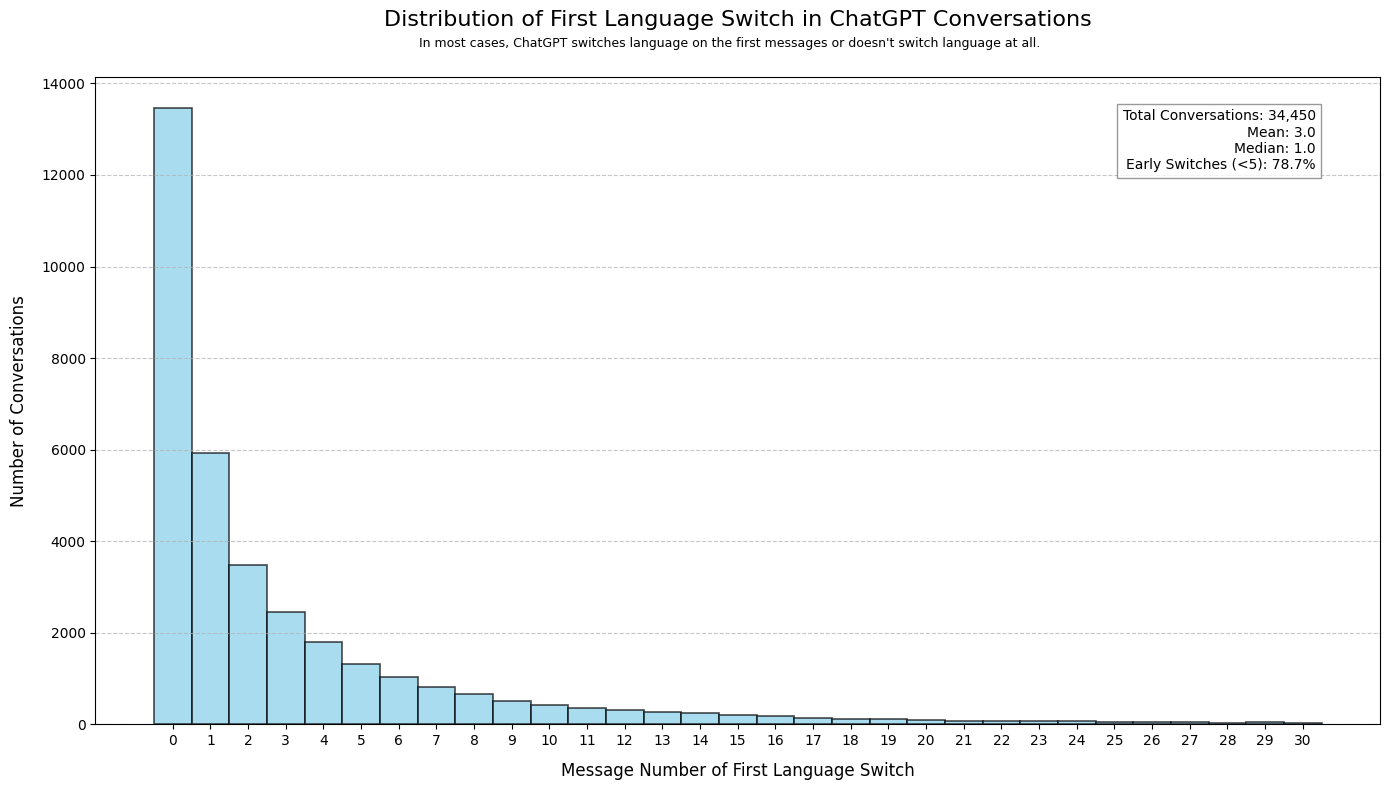

In [187]:
first_mismatches = different_lang_responses.groupby('post_number')[
    'pair_order'].min()
first_mismatches_series = first_mismatches.value_counts().sort_index()
upper_bound = np.percentile(first_mismatches, 99)
filtered_mismatches = first_mismatches[first_mismatches <= upper_bound]

mean_switch = filtered_mismatches.mean()
median_switch = filtered_mismatches.median()
total_samples = len(filtered_mismatches)

fig, ax = plt.subplots(figsize=(14, 8))

max_message = int(np.ceil(filtered_mismatches.max()))
bins = np.arange(0, max_message + 2) - 0.5

n, bins, patches = plt.hist(filtered_mismatches,
                            bins=bins,
                            color='skyblue', 
                            edgecolor='black', 
                            alpha=0.7,
                            linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Distribution of First Language Switch in ChatGPT Conversations\n',
          fontsize=16, pad=20)
plt.xlabel('Message Number of First Language Switch', fontsize=12, labelpad=10)
plt.ylabel('Number of Conversations', fontsize=12, labelpad=10)

stats_text = (f'Total Conversations: {total_samples:,}\n'
              f'Mean: {mean_switch:.1f}\n'
              f'Median: {median_switch:.1f}\n'
              f'Early Switches (<5): {len(filtered_mismatches[filtered_mismatches < 5])/total_samples*100:.1f}%')
plt.text(0.95, 0.95, stats_text,
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         verticalalignment='top',
         horizontalalignment='right',
         fontsize=10)

plt.figtext(0.525, 0.935,
            'In most cases, ChatGPT switches language on the first messages or doesn\'t switch language at all.',
            ha='center', fontsize=9)

plt.xticks(np.arange(0, max_message + 1, 1))

plt.tight_layout()
plt.show()

### TDA: Sentiment Analysis

### TDA: Topic Categorization

### TDA: User Satisfaction Rate

### TDA: Identify prompt techniques and how user satisfaction rate is affected by them. 